In [18]:
from __future__ import division
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import theano
import theano.tensor as T
from theano.tensor.shared_randomstreams import RandomStreams
%matplotlib inline

<h1>Modeling Ordinal(Rank ?) Variables<br /><small>Jonah Williams</small></h1>

Most frequently, the inputs to our models will be real or binary variables.  For example, a real variable representing salary might take on values such as 20,000 , 54,000, 60,000.  For the purposes of this example, we will always be interested in interpolating values, that is we only need to worry about predictions from data we've seen.  We can therefore consider the normalization of real valued data below:

$$X = \frac{x - min(X)}{max(X) - min(X)}$$

This will map our data in some domain $[min(X), max(X)]$ to codomain $[0, 1]$.  Additionally, this is an affine transformation (I think) such that the difference between values a and b in the domain is proportional to their difference in the codomain.

<img src="real_plot.png"/>
The difference between the first and second points $d_1$ is proportional two the transformed difference $f(d_1)$, and likewise for $d_2$.  Thus we can represent a subset of real valued variables, that is they must have a smallest and largest value (so not all reals) in the range [0, 1] for input to our neural network.  Alternatively, we could transform them to any arbitrary range $[a, b]$


Ordinal Variables are different, the read-headed stepchild of binary and real valued data.  An ordinal variables takes on values $X = \{A, B, C, ... \}$.  While we know in a general sense that $A < B$ and $B < C$, we don't know by how much (in terms of a real valued quantity).  Furthermore, we can't simply map it to some numbers $0, 1, 2,...$ because we also do not know if the intervals between each ordinal are the same.  For example, below we map our variables $A, B, C, D$ to $[1, 2, 3, 4]$.  However this may be inappropriate depending on how to ordinals were impleneted.

<img src="ordinal_plot.png"/>

However, if we knew these intervals we could map our ordinal data to some arbitrary range and use it as neural network input.  It turns out we can learn these intervals from the data itself.  Consider the following reparameterization below.

$$\begin{bmatrix}A \\ B \\ C \\ D\end{bmatrix} = \begin{bmatrix} 0 & 0& 0\\1& 0& 0\\1& 1& 0\\ 1& 1& 1\end{bmatrix}$$

We create variables $x_1, x_2, x_3$ which represent the distance (in terms of the new space) and try to learn weights $w_1, w_2, w_3$ and bias $b$ such that $Wy + b $ accurately represents our ordinal variable in a real valued space.


$$\begin{bmatrix} 0 & 0& 0\\1& 0& 0\\1& 1& 0\\ 1& 1& 1\end{bmatrix} \begin{bmatrix}w_1 & w_2 & w_3 \end{bmatrix} + b$$


<img src="ordinal_transformed_plot.png"/>

Of course, if we wish to preserve the additional information i.e. the ordinal nature, we must restrict the weights to be greater than 0.

In [7]:
train = pd.read_csv('/Users/jonahwilliams/Downloads/train.csv', index_col='Id')[['Hazard','T1_V4']]
train.head()

,Hazard,T1_V4
Id,,
1,1,N
2,4,H
3,1,N
4,1,N
5,1,N


In [8]:
letters = 'abcdefghijklmnopqrstuvwxyz'
mapping = dict([(a.upper(), i) for i, a in enumerate(letters)])

def create_rank(x):
    row = np.zeros(26, dtype=np.int)
    for i in xrange(x + 1):
        row[i] = 1
    return row

#Letters = ['T2_V13','T2_V5','T1_V16', 'T1_V15','T1_V12', 'T1_V11',
#           'T1_V9', 'T1_V8', 'T1_V7', 'T1_V5', 'T1_V4']
#Binary = ['T2_V12', 'T2_V11', 'T2_V3', 'T1_V17', 'T1_V6']

train['T1_V4'] = train['T1_V4'].map(mapping)
train['T1_V4'] = train['T1_V4'].map(create_rank)
train.head()


,Hazard,T1_V4
Id,,
1,1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ..."
2,4,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ..."
3,1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ..."
4,1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ..."
5,1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ..."


In [54]:
y = train['Hazard'].values
y.shape = (-1, 1)
y = y.astype(float)
basic = train['T1_V4'].values
x = np.zeros((len(basic), len(basic[0])))
for i in xrange(len(basic)):
    for j in xrange(len(basic[0])):
        x[i, j] = basic[i][j]

In [55]:
x

array([[ 1.,  1.,  1., ...,  0.,  0.,  0.],
       [ 1.,  1.,  1., ...,  0.,  0.,  0.],
       [ 1.,  1.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 1.,  1.,  1., ...,  0.,  0.,  0.],
       [ 1.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1.,  1.,  0., ...,  0.,  0.,  0.]])

In [56]:
y

array([[  1.],
       [  4.],
       [  1.],
       ..., 
       [  3.],
       [ 14.],
       [  9.]])

Our basic model for prediction of y is 

$$ \sigma(XW_1 + b_1)W_2 + b_2 $$

In [60]:
class RankRegression(object):
    
    def __init__(self, num_ranks):
        np_rng = np.random.RandomState(1234)
        theano_rng = RandomStreams(np_rng.randint(1234))
        W_1 = np.asarray(np_rng.uniform(
                            low=0, high=np.sqrt(6. / (num_ranks + 1)),
                            size=(num_ranks, 1)),
                   dtype=theano.config.floatX)
        W_2 = np.asarray(np_rng.uniform(
                            low=np.sqrt(3),
                            high=np.sqrt(3),
                            size=(1, 1)),
                   dtype=theano.config.floatX)
        b_1 = np.zeros((1,), dtype=theano.config.floatX)
        b_2 = np.zeros((1,), dtype=theano.config.floatX)
        
        self.x = T.dmatrix('x')
        self.y = T.dmatrix('y')
        self.input = self.x
        self.W_1 = theano.shared(value=W_1, name="W_1", borrow=True)
        self.W_2 = theano.shared(value=W_2, name="W_2", borrow=True)
        self.b_1 = theano.shared(value=b_1, name="b_1", borrow=True)
        self.b_2 = theano.shared(value=b_2, name="b_2", borrow=True)
        self.output_1 = T.nnet.sigmoid(T.dot(self.input, self.W_1) + self.b_1)
        self.output_2 = T.dot(self.output_1, self.W_2) + self.b_2
        self.params = [self.W_1, self.W_2, self.b_1, self.b_2]
        self.cost = T.mean((self.output_2 - self.y)**2)
        
    def optimize(self, dataset, learning_rate=0.01):
        train_x, train_y = dataset

        gparams = T.grad(self.cost, self.params)
        updates = []
        for param, gparam in zip(self.params, gparams):
            if param == "W_1":
                updates.append((param, max(param - gparam * learning_rate, 0)))
            else:
                updates.append((param, param - gparam * learning_rate))
     
        train = theano.function(
            inputs=[],
            outputs=self.cost,
            updates=updates,
            givens={
                self.x: train_x,
                self.y: train_y
            },
            name='train'
        )
        return train
        

In [65]:
experiment = RankRegression(len(x[0]))
train = experiment.optimize((x, y))
errors = []
for i in xrange(100):
    errors.append(train())

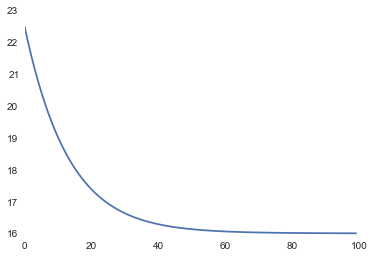

In [66]:
plt.plot(errors)
plt.show()

In [74]:
weights, bias = experiment.params[0].get_value(), experiment.params[1].get_value()

In [80]:
intervals = [(letter.upper(), w[0]) for letter, w in zip("abcdefghijklmnopqrstuvwxyz", weights)]

In [90]:
df = pd.DataFrame(intervals)
df.loc[0, 1] = df.loc[0, 1] + bias[0]
df['interval'] = np.cumsum(df[1])
df[[0, 'interval']]

,0,interval
0,A,3.352291
1,B,3.941798
2,C,4.284826
3,D,4.705650
4,E,5.168575
5,F,5.287705
6,G,5.429407
7,H,5.857781
8,I,5.973220
9,J,6.068540


<h3>Chart Generation Below</h3>

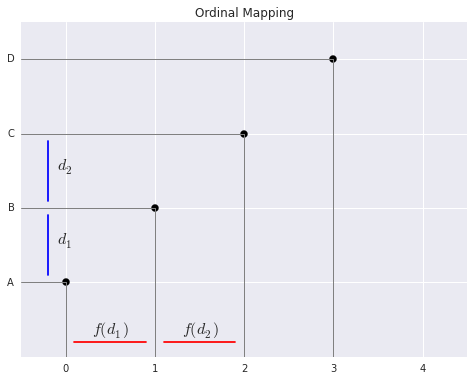

In [95]:
domain = np.array([1, 2, 3, 4])
codomain = np.array([0, 1, 2, 3])
plt.figure(figsize=(8, 6))

sns.set_style("darkgrid")
for i in xrange(len(domain)):
    plt.plot([codomain[i], codomain[i]], [0, domain[i]], linewidth=1, color="grey")
    plt.plot([-0.5, codomain[i]], [domain[i], domain[i]], linewidth=1, color="grey")

plt.plot([0.1, 0.9], [0.2, 0.2], "-", color="red")
plt.plot([1.1, 1.9], [0.2, 0.2], "-", color="red")
plt.plot([-0.2, -0.2], [1.1, 1.9], "-", color="blue")
plt.plot([-0.2, -0.2], [2.1, 2.9], "-", color="blue")
plt.text(-0.1, 1.5, "$d_1$", fontsize=16)
plt.text(-0.1, 2.5, "$d_2$", fontsize=16)
plt.text(0.3, 0.3, "$f(d_1)$", fontsize=16)
plt.text(1.3, 0.3, "$f(d_2)$", fontsize=16)
plt.title("Ordinal Mapping")
plt.scatter(codomain, domain, color="black",s=50)
plt.ylim([0, 4.5])
plt.xlim([-0.5, 4.5])
plt.yticks([1, 2, 3, 4],['A','B','C','D'])
plt.savefig("ordinal_plot.png")
plt.show()

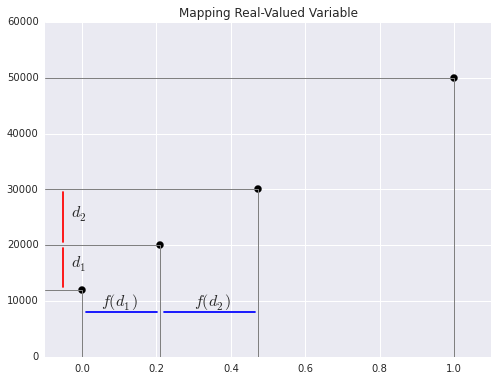

In [96]:
domain = np.array([12000, 20000, 30000, 50000])
codomain = (domain - np.min(domain)) / (np.max(domain) - np.min(domain))
plt.figure(figsize=(8, 6))

sns.set_style("darkgrid")
for i in xrange(len(domain)):
    plt.plot([codomain[i], codomain[i]], [0, domain[i]], linewidth=1, color="grey")
    plt.plot([-0.1, codomain[i]], [domain[i], domain[i]], linewidth=1, color="grey")
    
plt.plot([-.05, -0.05], [domain[0] + 500, domain[1] - 500], "-", color="red")
plt.plot([-.05, -0.05], [domain[1] + 500, domain[2] - 500], "-", color="red")
plt.plot([codomain[0] + 0.01, codomain[1] - 0.01], [8000, 8000], "-", color="blue")
plt.plot([codomain[1] + 0.01, codomain[2] - 0.01], [8000, 8000], "-", color="blue")

plt.text(-0.03, 16000, "$d_1$", fontsize=16)
plt.text(0.05, 9000, "$f(d_1)$", fontsize=16)
plt.text(-0.03, 25000, "$d_2$", fontsize=16)
plt.text(0.3, 9000, "$f(d_2)$", fontsize=16)
plt.scatter(codomain, domain, color="black",s=50)
plt.title("Mapping Real-Valued Variable")
plt.xlim(-0.1, 1.1)
plt.ylim(0)
plt.savefig("real_plot.png")
plt.show()

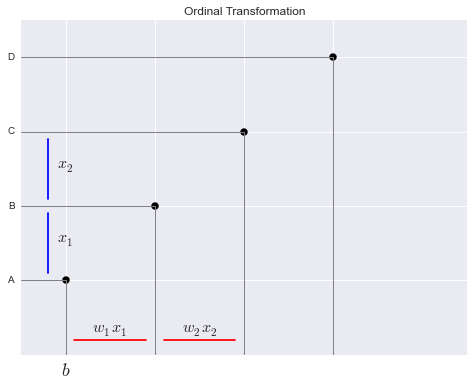

In [94]:
domain = np.array([1, 2, 3, 4])
codomain = np.array([0, 1, 2, 3])
plt.figure(figsize=(8, 6))

sns.set_style("darkgrid")
for i in xrange(len(domain)):
    plt.plot([codomain[i], codomain[i]], [0, domain[i]], linewidth=1, color="grey")
    plt.plot([-0.5, codomain[i]], [domain[i], domain[i]], linewidth=1, color="grey")

plt.plot([0.1, 0.9], [0.2, 0.2], "-", color="red")
plt.plot([1.1, 1.9], [0.2, 0.2], "-", color="red")
plt.plot([-0.2, -0.2], [1.1, 1.9], "-", color="blue")
plt.plot([-0.2, -0.2], [2.1, 2.9], "-", color="blue")
plt.text(-0.1, 1.5, "$x_1$", fontsize=16)
plt.text(-0.1, 2.5, "$x_2$", fontsize=16)
plt.text(0.3, 0.3, "$w_1 x_1$", fontsize=16)
plt.text(1.3, 0.3, "$w_2 x_2$", fontsize=16)
plt.title("Ordinal Transformation")
plt.scatter(codomain, domain, color="black",s=50)
plt.ylim([0, 4.5])
plt.xlim([-0.5, 4.5])
plt.xticks([0,1,2,3],['$b$','','',''], size=18)
plt.yticks([1, 2, 3, 4],['A','B','C','D'])
plt.savefig("ordinal_transformed_plot.png")
plt.show()